In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import glob
import xarray as xr
import cartopy.crs as ccrs
import sys
%matplotlib inline
from matplotlib.gridspec import GridSpec
import warnings
import matplotlib as mpl
import matplotlib.transforms as mtransforms

sys.path.append('/global/homes/j/jhollo/repos/climate_util')
import climate_toolbox as ctb
from climate_artist import horizontal_slice as plthor
from climate_artist import horizontal_slice as pltvert

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

print('done')

done


In [2]:
# ========== read data ==========

# --- pm
lv_loc = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_mass_ens_latlon'
# new dest where I remapped jerry's corrected ens01_mass1.00X... (ONLY masssx=1.00 BELOW WILL WORK WITH THIS CHOICE OF DATA)
#lv_loc = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/tmp2'

out    = '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/hswPaperFigs'
vars   = ['AOD', 'U']
N = 5

#massx='0.25'
#massx='0.50'
#massx='0.90'
#massx = '1.00'
massx = '1.10'
#massx='1.50'
#massx='2.00'

print('done')

done


In [3]:
print('opening data...')
ens_lv = [xr.open_dataset(sorted(glob.glob('{}/*ens0{}*mass{}X/*.h2*'.format(lv_loc, i+1, massx)))[0])[vars]
                                                                     for i in range(N)]

# --- reassign time dim to day integer, slice to day 300
print('converting time coordinates...')
for i in range(len(ens_lv)):
    print('...ens{}...'.format(i+1))
    ens_lv[i] = ens_lv[i].assign_coords(time=ctb.time2day(ens_lv[i].time)).sel(time = slice(0, 300))
    #ens_lv[i] = ens_lv[i].sel(time=ens_lv[i].time % 2 == 0)

overwrite=False
try:
    if(overwrite): raise FileNotFoundError
    ensmean_lv = xr.open_dataset('/pscratch/sd/j/jhollo/tmp/ensmean_lv_m{}X.nc'.format(massx))
    ensmean_read = True
except FileNotFoundError:
    print('building ensmean zeros...')
    ensmean_lv = xr.zeros_like(ens_lv[0])
    ensmean_read = False

lat  = ens_lv[0]['lat']
lon  = ens_lv[0]['lon']
nlat, nlon = len(lat), len(lon)
time_lv = ens_lv[0].time

print('done')

opening data...
converting time coordinates...
...ens1...
...ens2...
...ens3...
...ens4...
...ens5...
done


In [4]:
# ========== compute ensemble mean ==========

if(ensmean_read):
    pass
else:
    print('computing ensemble mean...')
    for var in vars:
        print('var {}...'.format(var))
        for i in range(N):
            print('...ens0{}...'.format(i+1))
            ensmean_lv[var] = ensmean_lv[var] + ens_lv[i][var]
    ensmean_lv = ensmean_lv / N
    
    print('writing ens mean to file...')
    ensmean_lv.to_netcdf('/pscratch/sd/j/jhollo/tmp/ensmean_lv_m{}X.nc'.format(massx))

print('done')

done


In [5]:
# ========== reduce variables ==========

print('reducing U...')
U_lv = [0] * 5
U_range = slice(-5, 35)
U_lev   = 133
weights = xr.DataArray(np.cos(np.deg2rad(lat)), coords={'lat':lat}).sel(lat=U_range)

for i in range(N):
    print('...ens0{}...'.format(i+1))
    U_lv[i] = ens_lv[i].sel({'lev':U_lev}, method='nearest').mean('lon')
    U_lv[i] = U_lv[i]['U'].sel({'lat':U_range})
    U_lv[i] = U_lv[i].weighted(weights).mean('lat')
print('done')

reducing U...
...ens01...
...ens02...
...ens03...
...ens04...
...ens05...
done


In [6]:
print('retrieving AOD...')
AOD_lv = [ens_lv[i]['AOD'] for i in range(5)]
print('done')

retrieving AOD...
done


In [7]:
print('reducing ensmean U...')

Uem_lv = ensmean_lv.sel({'lev':U_lev}, method='nearest').mean('lon')
Uem_lv = Uem_lv['U'].sel({'lat':U_range})
Uem_lv = Uem_lv.weighted(weights).mean('lat')

print('done')

reducing ensmean U...
done


creating figure...


/tmp/ipykernel_308122/465853738.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


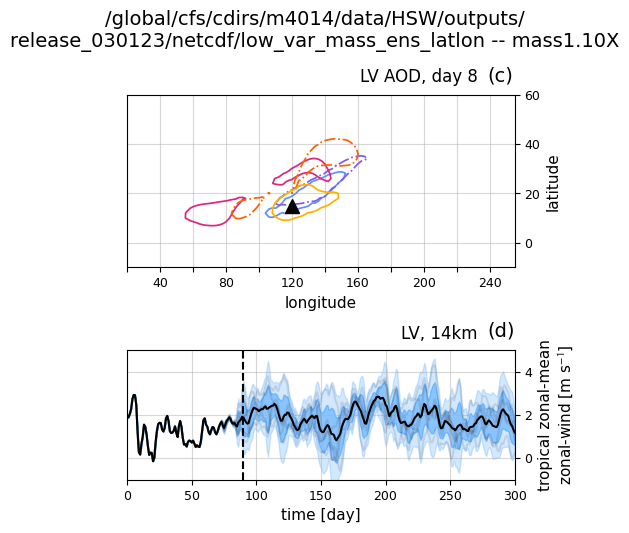

In [9]:
# ==================== plot ===========

plotting_day = 8
AOD_time_lv = plotting_day+90         # day to plot AOD
U_time_lv = AOD_time_lv       # day of injection in U

#clev_c = np.array([0.25, 0.5, 0.75]) + 1e-3
clev_c = np.array([0.6])
#clev_c = np.array([0.25, 0.75])

LON, LAT = np.meshgrid(lon, lat)
#colors = ['r', 'b', 'g', 'm', 'c']
colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
linestyles = ['-', '-.', '-', '-.', '-']

Ucolor = 'dodgerblue'

latlim      = [-10, 60]
lonlim      = [25, 255]
lonticks    = np.arange(20, 260, 20)

# =====================================

    
print('creating figure...')

fig = plt.figure(figsize=(5, 5))
gs = GridSpec(2, 1, height_ratios=[2, 1.5], hspace=0.55)
ax2 = fig.add_subplot(gs[0])
ax4 = fig.add_subplot(gs[1])

# ----------- plot ens members as colored contours

for i in range(N):
    var = AOD_lv[i].sel(time=AOD_time_lv)
    ax2.contour(lon, lat, var, levels=clev_c, linewidths=1.25, 
                colors=colors[i], linestyles=linestyles[i])
    ax2.plot([0,0], [0,0], color=colors[i], ls=linestyles[i], 
         label='ens0{}'.format(i+1))
ax2.plot([120], [15], 'k^', ms=10) 
ax2.plot([120], [180], 'k^', ms=6, label='injection location') #dummy

ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude') 
ax2.set_ylim(latlim)
ax2.set_xlim(lonlim)
ax2.set_xticks(lonticks)
ax2.grid(alpha=0.5)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax2.tick_params(left=False, right=True, labelleft=False, labelright=True)
ax2.yaxis.set_label_position("right")

#leg = ax2.legend(loc='upper right', bbox_to_anchor=(0.44, 1.33), 
#                 ncol=3, fancybox=False, framealpha=1, shadow=False)
#leg.get_frame().set_edgecolor('k')
#leg.get_frame().set_linewidth(0.75)

plt.text(0.905, 1.051, 'LV AOD, day 8', ha='right', va='bottom', 
         transform=ax2.transAxes, fontsize=BIG_SIZE)
    

# ----------- plot ens members as U time series

pstd_lv = xr.zeros_like(Uem_lv)
for i in range(N):
    ax4.plot(time_lv, U_lv[i], color='k', alpha=0.1)
    pstd_lv = pstd_lv + ((U_lv[i] - Uem_lv)**2).values
pstd_lv = pstd_lv / (N)
pstd_lv = np.sqrt(pstd_lv)

ax4.axvline(U_time_lv-plotting_day, color='k', ls='--', label='time of injection', zorder=99)
ax4.plot(time_lv, Uem_lv, color='k', lw=1.5, label='ensemble mean')
ax4.fill_between(time_lv, Uem_lv-pstd_lv, Uem_lv+pstd_lv, color=Ucolor, 
                 alpha=0.4, label='1 std')
ax4.fill_between(time_lv, Uem_lv-2*pstd_lv, Uem_lv+2*pstd_lv, color=Ucolor, 
                 alpha=0.2, label = '2 std')
ax4.grid(alpha=0.5)
ax4.set_ylabel('tropical zonal-mean\nzonal-wind ' + r'[m s$^{-1}$]')
ax4.set_xlabel('time [day]')
#ax4.set_title('lev=50 hPa, lat={} degN'.format(, lat[j]))
ax4.set_xlim([0, 300])
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.text(0.905, 1.061, 'LV, 14km'.format(U_lev), ha='right', va='bottom', 
         transform=ax4.transAxes, fontsize=BIG_SIZE)

#leg = ax4.legend(bbox_to_anchor=(0.29, 1.43), ncol=2, fancybox=False, 
#                 framealpha=1, shadow=False)
#leg.get_frame().set_edgecolor('k')
#leg.get_frame().set_linewidth(0.75)

#ax4.set_ylim(-6,4)
#ax4.set_ylim(-2, 8)
ax4.set_ylim(-1, 5)

# ========================================

axs = [ax2, ax4]
axlabs = ['(c)', '(d)']
for i in range(len(axs)):
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    #if(i ==0 or i == 2): pos = [0.05, 1]
    #else:                pos = [1, 1]
    pos = [1,1]
    axs[i].text(pos[0], pos[1], axlabs[i], transform=axs[i].transAxes + trans,
               fontsize=BIGGER_SIZE, va='bottom', fontfamily='sans-serif')
    
ps = [pos for pos, char in enumerate(lv_loc) if char == '/']
psi = np.argmin(abs(np.array(ps) - len(lv_loc)/2))
fig.suptitle(lv_loc[:ps[psi]+1]+'\n'+lv_loc[ps[psi]+1:]+' -- mass{}X'.format(massx), y=1.05)

plt.subplots_adjust(hspace=0)
fig.tight_layout()
plt.savefig('figs/ensemble_plumes_{}_{}X_NERSC_BAD.pdf'.format(lv_loc.split('outputs/')[-1].replace('/','-'), massx), dpi=300, bbox_inches='tight')
plt.show()